In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#plt.style.use('classic') 

key_dict={
    'renewable': 'wind|renewable|solar|bio|green|biofuel|battery',
    'climate': 'tree|emission|warm|environment|weather|climate|arctic|green|meteorolo|dioxide|atmosphere|flood|plastic|antarctic|carbon|pollution|methane',
    'gas' : 'gas',
    'oil' : 'drillers|oil|crude',
    'energy': 'electricity|coal|energy|mining|power|fuel',
    'Bloomberg' : 'stock|bitcoin|recession|crises|finance|fund|bond|Bloomberg',
    'coronavirus' : 'COVID-19|coronavirus|lockdown|pandemic|virus|distancing|health|death|medic'
}

input_file_news = "C:\\Users\\User\\Documents\\Final Project\\Bloomberg News.xlsx"
input_file_tweets = "D:\\Final_project\\Tweets_sentiment.csv"
input_oil_for_news = "C:\\Users\\User\\Documents\\Final Project\\oil_15022020_06052020.csv"
input_oil_for_tweets = "C:\\Users\\User\\Documents\\Final Project\\oil_20032020_06052020.csv"
column_names = ['created_at', 'text']
fieldnames = ['date', 'sentiment', 'n_sentiment', 
                'renewable', 'n_renewable', 
                'climate', 'n_climate',
                'gas', 'n_gas',
                'oil', 'n_oil',
                'energy', 'n_energy',
                'Bloomberg', 'n_Bloomberg',
                'coronavirus', 'n_coronavirus']



In [3]:
def check_word(pat, data):
    """Checks if a word is in the Tweeter dataset's text. 
    """
    prop = np.sum(data['text'].str.contains(pat, case = False, regex=True))
    return prop

def check_sentiment(pat, data):
    """Checks if a word is in the Tweeter dataset's text. 
    """
    bool_val = data['text'].str.contains(pat, case = False, regex=True)
    sent=bool_val*data['sentiment']
    return sent
#
#  Calculating proportions 
def append_df(df, dict):
    num= df.shape[0]
    column_names = ['created_at', 'text']
    df_p = pd.DataFrame( columns=['group', 'percent'])
    for key in dict.keys():
        print(key)
        pat = dict.get(key, 'Not Found')
        if pat != 'Not Found':
            prop = round(check_word(pat, df)/num, 2)*100
        #print( pat, prop)
            df_p = df_p.append({'group': key, 'percent': prop}, ignore_index=True)
    #df_p1 = pd.DataFrame.from_dict(df_p, orient='index', columns=['proportion'])    
    df_p = df_p.sort_values(by='percent', ascending=False)
    df_p.plot(kind='bar', x = 'group', ylim=(10,50), align='center', color="seagreen")
    plt.ylabel('Distribution of news by groups of words')
    plt.grid(b=True, color='0.4', alpha=0.3, linestyle='-.', linewidth=1) 
    plt.xticks(rotation=45)
    plt.title('Group of news by keywords')
    plt.show()

In [4]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


In [5]:
def tweets_distribution(df, dict):
    num= df.shape[0]
    sum_sent = 0
    df_p = pd.DataFrame( columns=['hashtags', 'percent'])
    sent_sum = np.sum(df['n_sentiment'])
    #print(sent_sum)
    for key in dict.keys():
        pat_sum = np.sum(df['n_'+str(key)])
        #print(key, pat_sum)
        sum_sent = sum_sent+pat_sum
        prop = pat_sum/sent_sum
        #print(key, prop)
        df_p = df_p.append({'hashtags': '#' + key, 'percent': pat_sum}, ignore_index=True)
        
    #df_p1 = pd.DataFrame.from_dict(df_p, orient='index', columns=['proportion'])  
    df_p['percent'] = df_p['percent']/sum_sent*100
    #print(df_p)
    df_p = df_p.sort_values(by='percent', ascending=False)
    df_p.plot(kind='bar', x = 'hashtags', ylim=(0,100), align='center', color="seagreen")
    plt.ylabel('Distribution of tweets by hashtags')
    plt.rcParams['figure.figsize'] = [20/2.54, 12/2.54]
    plt.grid(b=True, color='0.4', alpha=0.3, linestyle='-.', linewidth=1) 
    plt.xticks(rotation=45)
    plt.title('Group of Tweets by hashtags')
    plt.show()

In [6]:
# reading  News file
def reading_news(input_file ):
    column_names = ['created_at', 'text']
    ds_news = pd.read_excel(input_file,  encoding="utf-8" ) #, header=0, index_col=0, parse_dates=True, squeeze=True)
    #print(ds_news.shape)
    #print(ds_news.dtypes)
    #print(ds_news.head())
    fmt='%B %d, %Y, %H:%M %p'
    df_news = pd.DataFrame([],columns = column_names)
    for i in range(ds_news.shape[0]):
        cr_time = datetime.strptime(ds_news.Time[i].strip(), fmt)
        cr_text = ds_news.Title[i]+ds_news.Headline[i]
        df_news = df_news.append({'created_at' : cr_time, 'text': cr_text},  ignore_index=True)
        df_news['created_at'] = pd.to_datetime(df_news['created_at'])
    df_news.set_index('created_at', inplace = True)
    df_news.sort_index(axis = 0, inplace = True)
    return df_news


In [7]:
# Sentiment analysis
def sentim_analysis(df, key_dict):
    
    sid = SentimentIntensityAnalyzer()
    sentiment_scores= df['text'].apply(sid.polarity_scores)
    df['sentiment'] = sentiment_scores.apply(lambda x: x['compound'])
    #calculating sentiment for each keyword
    for search_key in key_dict:
         df[search_key] = check_sentiment(key_dict[search_key], df)
    # Resampling with frequency 1 Day
    sent_df=df.drop(['text'], axis = 1)
    #print(sent_df.info())
    sent_new = sent_df.resample('D').mean().ffill()
    #print(sent_new.info())
    #print(sent_new.head(3))
    #print(sent_new.tail(3))
    return sent_new


In [8]:
def time_format(x):
    fmt='%Y-%m-%d'
    return datetime.strptime(x, fmt)
#
def new_mean(df):
    df_new = pd.DataFrame([], columns = ['date', 'sentiment'])
    data_set = set(df['date'])
    for d in data_set:
        one_day_df = df[df['date']==d]
        #one_day_df['multip'] = one_day_df['sentiment'] * one_day_df['n_tweets']
        avg_sentiment =(one_day_df['sentiment'].sum())/(one_day_df['n_sentiment'].sum())
        avg_renewable =(one_day_df['renewable'].sum())/(one_day_df['n_renewable'].sum())
        avg_climate =(one_day_df['climate'].sum())/(one_day_df['n_climate'].sum())
        avg_gas =(one_day_df['gas'].sum())/(one_day_df['n_gas'].sum())
        avg_oil =(one_day_df['oil'].sum())/(one_day_df['n_oil'].sum())
        avg_energy =(one_day_df['energy'].sum())/(one_day_df['n_energy'].sum())
        avg_Bloomberg =(one_day_df['Bloomberg'].sum())/(one_day_df['n_Bloomberg'].sum())
        avg_coronavirus =(one_day_df['coronavirus'].sum())/(one_day_df['n_coronavirus'].sum())
        df_new=df_new.append({'date': d, 'sentiment' : avg_sentiment, 
                              'renewable' : avg_renewable,
                              'climate' : avg_climate,
                              'gas' : avg_gas,
                              'oil' : avg_oil,
                              'energy' : avg_energy,
                              'Bloomberg' : avg_Bloomberg,
                              'coronavirus': avg_coronavirus }, ignore_index=True)
    return df_new
#
def daily_mean(df, fnames):
    df_new = pd.DataFrame([], columns = fnames)
    df['date']=df['date'].apply(lambda x: x[0:10])
    #print(df.head())
    df['date'] = df['date'].apply(time_format)
    df['date'] = pd.to_datetime(df['date'])
    print(df.head())
    df_new =new_mean(df)
    #print(df_new)
    # print('df_tweets')
    return df_new

# read oil data for Bloomberg_news

In [9]:
# MAIN MODULE
# read oil data for Bloomberg_news
oil_df = pd.read_csv(input_oil_for_news)
#print(oil_df.describe)
oil_df['Date'] = pd.to_datetime(oil_df['Date'])
new_oil_df = oil_df[['Date', 'Close']]
print(new_oil_df.describe())
new_oil_df.set_index('Date', inplace = True)
# resampling
new_oil_df =new_oil_df.resample('D').mean().ffill()
w_oil_df =new_oil_df.resample('W').mean()
# Normalizing between -1 and 1
new_oil_df['Close_n']= 2*((new_oil_df['Close'] - new_oil_df['Close'].min())/(new_oil_df['Close'].max()-new_oil_df['Close'].min()))-1
w_oil_df['Close_n']= 2*((w_oil_df['Close'] - w_oil_df['Close'].min())/(w_oil_df['Close'].max()-w_oil_df['Close'].min()))-1
print(new_oil_df.describe())
print(w_oil_df.describe())

           Close
count  66.000000
mean   29.279546
std    13.576290
min    -2.720000
25%    20.280001
50%    25.280000
75%    43.747500
max    53.779999
           Close    Close_n
count  80.000000  80.000000
mean   29.627500   0.145044
std    13.408770   0.474647
min    -2.720000  -1.000000
25%    20.280001  -0.185841
50%    25.850001   0.011327
75%    44.617500   0.675664
max    53.779999   1.000000
           Close    Close_n
count  13.000000  13.000000
mean   30.738517  -0.091225
std    13.993315   0.689738
min    12.301429  -1.000000
25%    22.785001  -0.483259
50%    24.817143  -0.383093
75%    44.258572   0.575186
max    52.877143   1.000000


# Plotting data about oil

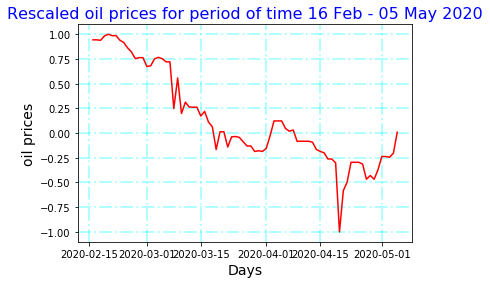

In [10]:
plt.figure() 
# plotting Oil 
plt.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days', fontsize=14)
plt.ylabel('oil prices', fontsize=14)
plt.title('Rescaled oil prices for period of time 16 Feb - 05 May 2020', fontsize=16, color = 'blue')
plt.rcParams['figure.figsize'] = [30/2.54,12/2.54]
#plt.legend(( 'oil'), loc='best')

plt.show()

# read tweets

Reading tweets 

                        date  sentiment  n_sentiment  renewable  n_renewable  \
0  2020-03-22 10:25:21+00:00   444.5703        20000    56.4734          195   
1  2020-03-22 12:07:26+00:00   879.2693        20000    39.0486          172   
2  2020-03-22 14:30:22+00:00  1084.5701        20000    44.6460          177   
3  2020-03-22 16:17:07+00:00   702.8050        20000    51.3927          195   
4  2020-03-22 19:22:02+00:00   537.7621        10009    27.5653          106   

   climate  n_climate       gas  n_gas       oil  n_oil    energy  n_energy  \
0  -0.2131        249 -459.7682   1221 -441.7545   1203  152.3704       377   
1   6.9718        310 -447.0456   1199 -429.1356   1175  136.4780       366   
2  27.6859        319 -293.9772    815 -292.9111    797  154.1338       393   
3  10.3128        335 -192.3426    560 -197.0087    546  151.1200       493   
4   1.0002        182  -70.8697    214  -69.1182    202   56.9371       285   

   Bloomberg  n_Bloomberg  

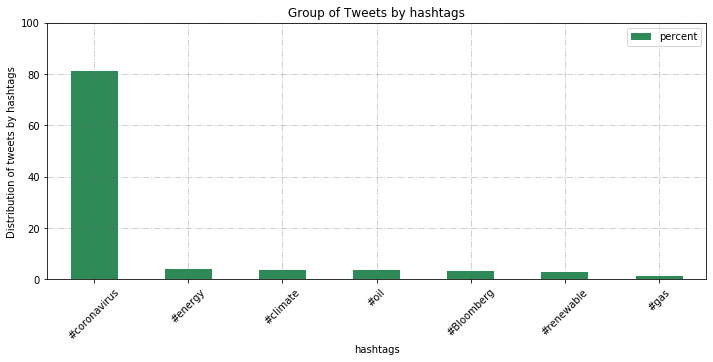

        date  sentiment  n_sentiment  renewable  n_renewable  climate  \
0 2020-03-22   444.5703        20000    56.4734          195  -0.2131   
1 2020-03-22   879.2693        20000    39.0486          172   6.9718   
2 2020-03-22  1084.5701        20000    44.6460          177  27.6859   
3 2020-03-22   702.8050        20000    51.3927          195  10.3128   
4 2020-03-22   537.7621        10009    27.5653          106   1.0002   

   n_climate       gas  n_gas       oil  n_oil    energy  n_energy  Bloomberg  \
0        249 -459.7682   1221 -441.7545   1203  152.3704       377    -3.8148   
1        310 -447.0456   1199 -429.1356   1175  136.4780       366    -4.3603   
2        319 -293.9772    815 -292.9111    797  154.1338       393    -0.7029   
3        335 -192.3426    560 -197.0087    546  151.1200       493   -11.7761   
4        182  -70.8697    214  -69.1182    202   56.9371       285   -13.0472   

   n_Bloomberg  coronavirus  n_coronavirus  
0          100     609.6054  

In [11]:
# read tweets
print('Reading tweets', '\n')
df_daily = pd.DataFrame([])
tweets_list = pd.DataFrame([], columns = fieldnames)
tweets_list  = pd.read_csv(input_file_tweets, encoding="utf-8")
print(tweets_list.head())
tweets_distribution(tweets_list, key_dict)
df_daily = daily_mean(tweets_list, fieldnames)
df_daily= df_daily.sort_values('date')
print(df_daily.head())
print(df_daily.tail())
df_daily = df_daily.set_index('date')
df_weekly = df_daily.resample('W').mean()
print(df_daily.shape)
print(df_daily.describe())

In [12]:
df_daily.to_csv("D:/Final_project/df_daily.csv",  index=False, line_terminator='\n')

# Correlation matrix TWEETS

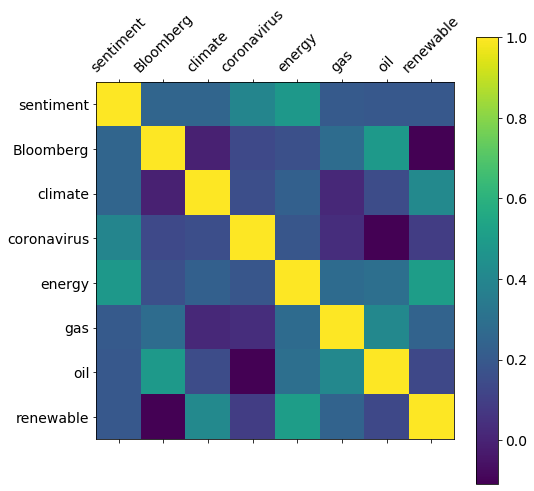

In [13]:
# Correlation matrix TWEETS
f = plt.figure(figsize=(19, 15))
plt.matshow(df_daily.corr(), fignum=f.number)
plt.xticks(range(df_daily.shape[1]), df_daily.columns, fontsize=14, rotation=45)
plt.yticks(range(df_daily.shape[1]), df_daily.columns, fontsize=14)
cb = plt.colorbar()
f.set_size_inches(8,8)
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix between group of tweets', fontsize=16);

# Reading news

Reading news
renewable
climate
gas
oil
energy
Bloomberg
coronavirus


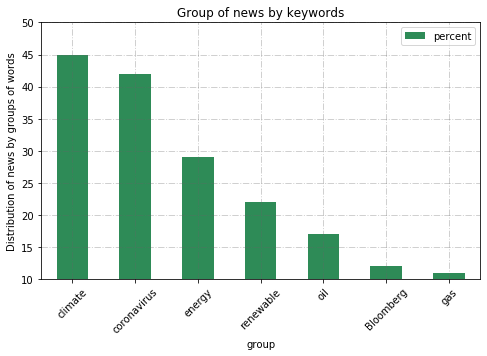

In [14]:
# Reading news
print('Reading news')
news_list = pd.DataFrame([],columns = column_names)
news_list = reading_news(input_file_news)
append_df(news_list, key_dict)
#sent_new = news_list.resample('D').mean().ffill()

# Sentiment analysis for Bloomberg news

In [16]:
# Sentiment analysis for Bloomberg news
#
sent_news = pd.DataFrame([])
sent_news = sentim_analysis(news_list, key_dict)
print(sent_news)
sent_news.to_csv('sent_news.csv')
print(sent_news.describe())
print(sent_news.head())
sent_new = sent_news.resample('D').mean().ffill()
sent_new.to_csv('Bloomberg_daily.csv')
w_sent_new = sent_news.resample('W').mean().ffill()

            sentiment  renewable   climate       gas       oil    energy  \
created_at                                                                 
2020-02-16   0.051600    0.00000  0.051600  0.000000  0.000000  0.000000   
2020-02-17   0.051600    0.00000  0.051600  0.000000  0.000000  0.000000   
2020-02-18  -0.836300    0.00000  0.000000  0.000000  0.000000  0.000000   
2020-02-19   0.288333    0.00000  0.034233  0.126833  0.126833  0.000000   
2020-02-20  -0.050220    0.00000 -0.129720  0.000000  0.000000  0.008980   
...               ...        ...       ...       ...       ...       ...   
2020-05-01  -0.210875    0.00000 -0.330050  0.000000 -0.152650  0.000000   
2020-05-02  -0.210875    0.00000 -0.330050  0.000000 -0.152650  0.000000   
2020-05-03  -0.647000    0.00000  0.000000  0.000000 -0.274167 -0.372833   
2020-05-04  -0.549100   -0.36145 -0.170200  0.000000  0.000000 -0.361450   
2020-05-05   0.413550    0.41355  0.413550  0.000000  0.000000  0.000000   

           

# Correlation matrix news

In [15]:
# Correlation matrix
print(sent_news.corr())

             sentiment  renewable   climate       gas       oil    energy  \
sentiment     1.000000   0.495277  0.743746  0.340334  0.439674  0.556835   
renewable     0.495277   1.000000  0.505821  0.201099  0.334296  0.552186   
climate       0.743746   0.505821  1.000000  0.272262  0.393707  0.452619   
gas           0.340334   0.201099  0.272262  1.000000  0.437704  0.395151   
oil           0.439674   0.334296  0.393707  0.437704  1.000000  0.599694   
energy        0.556835   0.552186  0.452619  0.395151  0.599694  1.000000   
Bloomberg     0.259166   0.013587  0.021365 -0.007402  0.344081  0.262706   
coronavirus   0.756215   0.205948  0.668163  0.189266  0.163770  0.258496   

             Bloomberg  coronavirus  
sentiment     0.259166     0.756215  
renewable     0.013587     0.205948  
climate       0.021365     0.668163  
gas          -0.007402     0.189266  
oil           0.344081     0.163770  
energy        0.262706     0.258496  
Bloomberg     1.000000     0.146662  
co

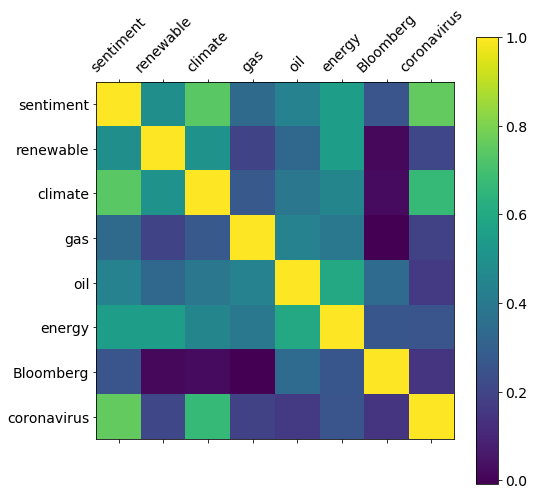

In [16]:
# Correlation matrix NEWS
f = plt.figure(figsize=(19, 15))
plt.matshow(sent_news.corr(), fignum=f.number)
plt.xticks(range(sent_news.shape[1]), sent_news.columns, fontsize=14, rotation=45)
plt.yticks(range(sent_news.shape[1]), sent_news.columns, fontsize=14)
cb = plt.colorbar()
f.set_size_inches(8,8)
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);

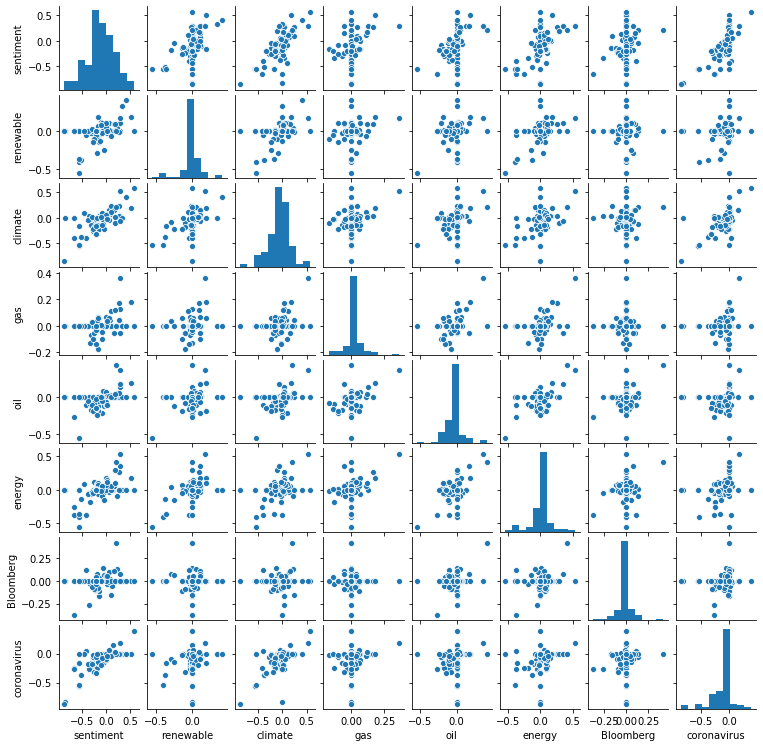

In [17]:
# Basic correlogram
g = sns.pairplot(sent_news)
g.fig.set_size_inches(10,10)
plt.show()


# Level of general sentiment in the news and in the two most popular group of news

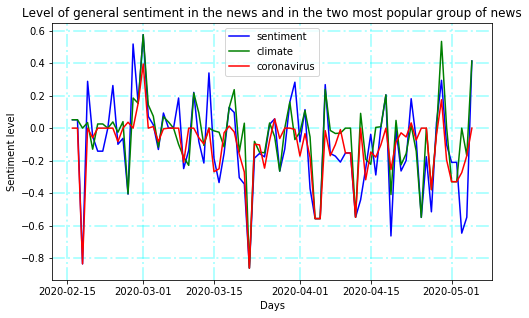

In [18]:
plt.figure() 
#plt.style.use('dark_background') 
# plotting Oil
#plt.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
# Plotting sentiment scores
plt.plot(sent_news.index, sent_news['sentiment'], color = 'blue')
#plt.plot(sent_news.index, sent_news['renewable'], color = 'blue')
#plt.plot(sent_news.index, sent_news['gas'], color = 'red')
#plt.plot(sent_news.index, sent_news['oil'], color = 'grey')
plt.plot(sent_news.index, sent_news['climate'], color = 'green')
#plt.plot(sent_news.index, sent_news['energy'], color = 'tomato')
#plt.plot(sent_news.index, sent_news['Bloomberg'], color = 'yellow')
plt.plot(sent_news.index, sent_news['coronavirus'], color = 'red')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
plt.ylabel('Sentiment level')
plt.title('Level of general sentiment in the news and in the two most popular group of news')
plt.rcParams['figure.figsize'] = [20/2.54, 12/2.54]
plt.legend(('sentiment', 'climate', 'coronavirus'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# Level of general sentiment in the news and in the two less popular group of news about gas and oil

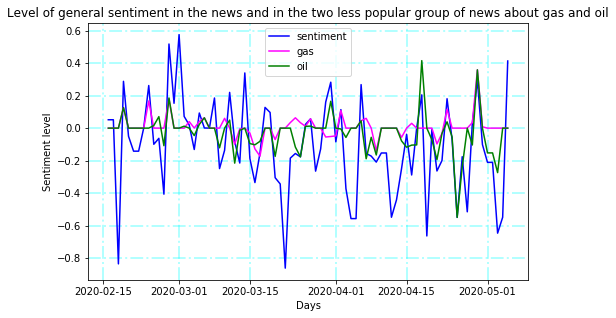

In [19]:
plt.figure() 
#plt.style.use('dark_background') 
# plotting Oil
#plt.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
# Plotting sentiment scores
plt.plot(sent_news.index, sent_news['sentiment'], color = 'blue')
#plt.plot(sent_news.index, sent_news['renewable'], color = 'blue')
plt.plot(sent_news.index, sent_news['gas'], color = 'magenta')
plt.plot(sent_news.index, sent_news['oil'], color = 'green')
#plt.plot(sent_news.index, sent_news['climate'], color = 'green')
#plt.plot(sent_news.index, sent_news['energy'], color = 'tomato')
#plt.plot(sent_news.index, sent_news['Bloomberg'], color = 'yellow')
#plt.plot(sent_news.index, sent_news['coronavirus'], color = 'red')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
plt.ylabel('Sentiment level')
plt.title('Level of general sentiment in the news and in the two less popular group of news about gas and oil')
plt.rcParams['figure.figsize'] = [20/2.54, 12/2.54]
plt.legend(('sentiment', 'gas', 'oil'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# Level of general sentiment in the news with markers

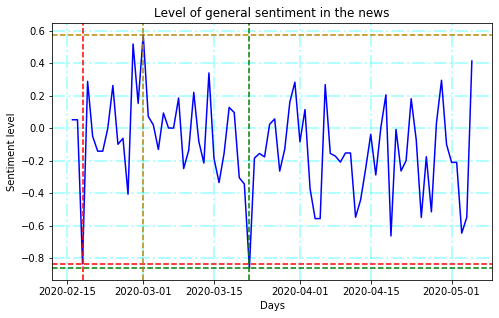

In [20]:
plt.figure() 
#plt.style.use('dark_background') 
# plotting Oil
#plt.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
# Plotting sentiment scores
plt.plot(sent_news.index, sent_news['sentiment'], color = 'blue')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
plt.ylabel('Sentiment level')
plt.title('Level of general sentiment in the news')
#sentmin = sent_news['sentiment'].close.min()
#ax2.fill_between(sent_news['sentiment'], sentmin, sent_news['sentiment'].close, facecolor='blue', alpha=0.5)
plt.rcParams['figure.figsize'] = [30/2.54, 16/2.54]
plt.axvline(pd.to_datetime('2020-02-18'), color='red', linestyle= '--')
#plt.axvline('2020-02-18', color='red', linestyle= '--')
plt.axhline(-0.836, color='red', linestyle='--')
plt.axvline(pd.to_datetime('2020-03-22'), color='green', linestyle= '--')
#plt.axvline('2020-03-22', color='green', linestyle= '--')
plt.axhline(-0.862, color='green', linestyle='--')
plt.axvline(pd.to_datetime('2020-03-01'), color='darkgoldenrod', linestyle= '--')
plt.axhline(0.576, color='darkgoldenrod', linestyle='--')
#plt.legend(('sentiment level'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# Price of oil

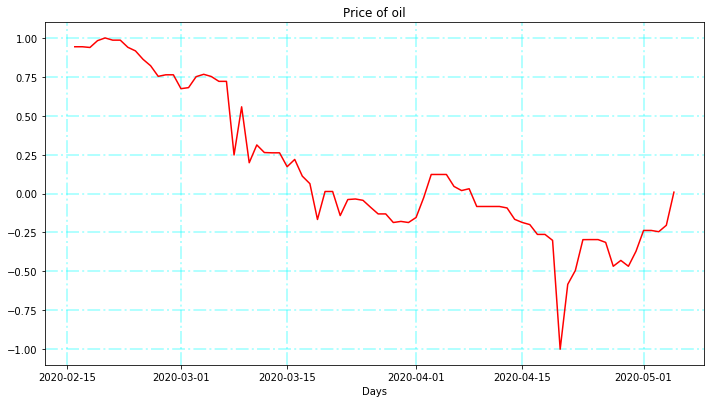

In [21]:
plt.figure() 
# plotting Oil
plt.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
# Plotting weekly price of oil
#plt.plot(w_oil_df['Close'].index, w_oil_df['Close'], color = 'blue')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
#plt.ylabel('Sentiment level')
plt.title('Price of oil')
plt.rcParams['figure.figsize'] = [20/2.54, 12/2.54]
#plt.legend(('daily', 'weekly'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# Price of oil daily and weekly

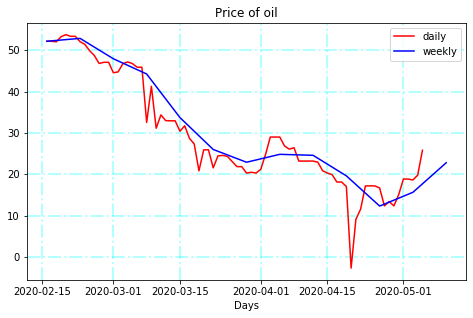

In [22]:
plt.figure() 
# plotting Oil
plt.plot(new_oil_df.index, new_oil_df['Close'], color = 'red')
# Plotting weekly price of oil
plt.plot(w_oil_df['Close'].index, w_oil_df['Close'], color = 'blue')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
#plt.ylabel('Sentiment level')
plt.title('Price of oil')
plt.rcParams['figure.figsize'] = [20/2.54, 12/2.54]
plt.legend(('daily', 'weekly'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# Correlation between group of news

In [23]:
# Correlation between group of news
sentiment_climate = sent_news['sentiment'].corr(sent_news['climate'])
sentiment_coronavirus = sent_news['sentiment'].corr(sent_news['coronavirus'])
print( "Coefficient of correlation between general sentiment of news and news about climate is ", sentiment_climate )
print( "Coefficient of correlation between general sentiment of news and news about coronavirus is ", sentiment_coronavirus )
print(sent_news.corr())

Coefficient of correlation between general sentiment of news and news about climate is  0.7437459028781647
Coefficient of correlation between general sentiment of news and news about coronavirus is  0.7562149636067228
             sentiment  renewable   climate       gas       oil    energy  \
sentiment     1.000000   0.495277  0.743746  0.340334  0.439674  0.556835   
renewable     0.495277   1.000000  0.505821  0.201099  0.334296  0.552186   
climate       0.743746   0.505821  1.000000  0.272262  0.393707  0.452619   
gas           0.340334   0.201099  0.272262  1.000000  0.437704  0.395151   
oil           0.439674   0.334296  0.393707  0.437704  1.000000  0.599694   
energy        0.556835   0.552186  0.452619  0.395151  0.599694  1.000000   
Bloomberg     0.259166   0.013587  0.021365 -0.007402  0.344081  0.262706   
coronavirus   0.756215   0.205948  0.668163  0.189266  0.163770  0.258496   

             Bloomberg  coronavirus  
sentiment     0.259166     0.756215  
renewable   

# Correlation news


In [74]:
# Calculating correlation
correlation = new_oil_df['Close_n'].corr(sent_new['sentiment'])
correlation_oil = new_oil_df['Close_n'].corr(sent_new['oil'])
print('daily frequency')
print( 'Correlation is ', round(correlation, 4))
print( 'Correlation_oil  is ', round(correlation_oil, 4))

correlation = w_oil_df['Close_n'].corr(w_sent_new['sentiment'])
correlation_oil = w_oil_df['Close_n'].corr(w_sent_new['oil'])

print('Weekly frequency')
print( 'Correlation is ', round(correlation, 4))
print( 'Correlation_oil  is ', round(correlation_oil, 4))

sma_oil_price =new_oil_df['Close_n'].rolling(window = 4).mean()
sma_news = sent_new['sentiment'].rolling(window = 4).mean()
sma_news_oil = sent_new['oil'].rolling(window = 4).mean()
correlation = sma_oil_price.corr(sma_news)
correlation_oil = sma_oil_price.corr(sma_news_oil)

print('SMA')
print( 'Correlation is ', round(correlation, 4))
print( 'Correlation_oil  is ', round(correlation_oil, 4))

daily frequency
Correlation is  0.2182
Correlation_oil  is  0.1956
Weekly frequency
Correlation is  0.7245
Correlation_oil  is  0.6139
SMA
Correlation is  0.4705
Correlation_oil  is  0.3942


# Correlation with lags

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Correlation with lag in  1 days is  0.1838
Correlation with lag in  2 days is  0.2258
Correlation with lag in  3 days is  0.2106
Correlation with lag in  4 days is  0.1303
Correlation with lag in  5 days is  0.1403
Correlation with lag in  6 days is  0.1507
Correlation with lag in  7 days is  0.0889
Correlation with lag in  8 days is  0.0836
Correlation with lag in  9 days is  0.022
Correlation with lag in  10 days is  -0.0169
Correlation with lag in  11 days is  -0.0028
Correlation with lag in  12 days is  0.0953
Correlation with lag in  13 days is  0.1376
Correlation with lag in  14 days is  0.0885
Correlation with lag in  15 days is  0.0899
Correlation with lag in  16 days is  0.1248
Correlation with lag in  17 days is  0.1599
Correlation with lag in  18 days is  0.156
Correlation with lag in  19 days is  0.173







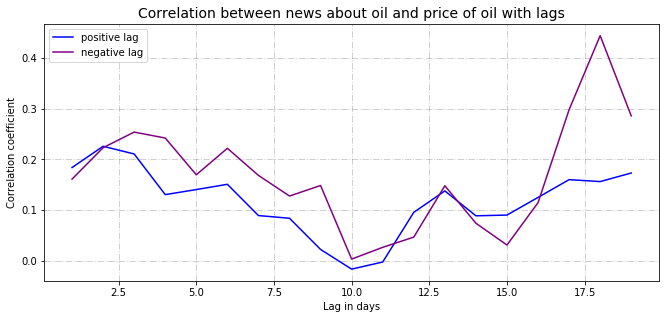

In [93]:
# Correlation with lags

correlation_df = pd.Series([])
correlation_df_rev = pd.Series([])
#
for i in range (1, 20):
        correlation_df[i] = new_oil_df['Close_n'].shift(periods = i).corr(
            sent_new['oil'].shift(periods = -i))
        correlation_df_rev[i] = new_oil_df['Close_n'].shift(periods = -i).corr(
            sent_new['oil'].shift(periods = i))
        print( 'Correlation with lag in ', i, 'days is ' , round(correlation_df[i], 4))
print('\n\n\n\n')        
plt.plot(correlation_df, color = 'blue')
plt.plot(correlation_df_rev, color = 'purple')
plt.rcParams['figure.figsize'] = [28/2.54, 12/2.54]
plt.title('Correlation between news about oil and price of oil with lags', fontsize = 14)
plt.xlabel('Lag in days')
plt.legend(('positive lag', 'negative lag'), loc='best')
plt.ylabel('Correlation coefficient')
plt.grid(b=True, color='0.4', alpha=0.3, linestyle='-.', linewidth=1) 
plt.show()

#  Correlation tweets about oil lags

Correlation is  0.1956
Correlation with lag in  1 day is  0.1838
Correlation with lag in  2 day is  0.2258
Correlation with lag in  3 day is  0.2106
Correlation with lag in  4 day is  0.1303
Correlation with lag in  5 day is  0.1403
Correlation with lag in  6 day is  0.1507
Correlation with lag in  7 day is  0.0889
Correlation with lag in  8 day is  0.0836
Correlation with lag in  9 day is  0.022
Correlation with lag in  10 day is  -0.0169
Correlation with lag in  11 day is  -0.0028
Correlation with lag in  12 day is  0.0953
Correlation with lag in  13 day is  0.1376
Correlation with lag in  14 day is  0.0885
Correlation with lag in  15 day is  0.0899
Correlation with lag in  16 day is  0.1248
Correlation with lag in  17 day is  0.1599
Correlation with lag in  18 day is  0.156
Correlation with lag in  19 day is  0.173
Correlation with lag in  20 day is  0.2057
Correlation with lag in  21 day is  0.2012
Correlation with lag in  22 day is  0.2217
Correlation with lag in  23 day is  0.153

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


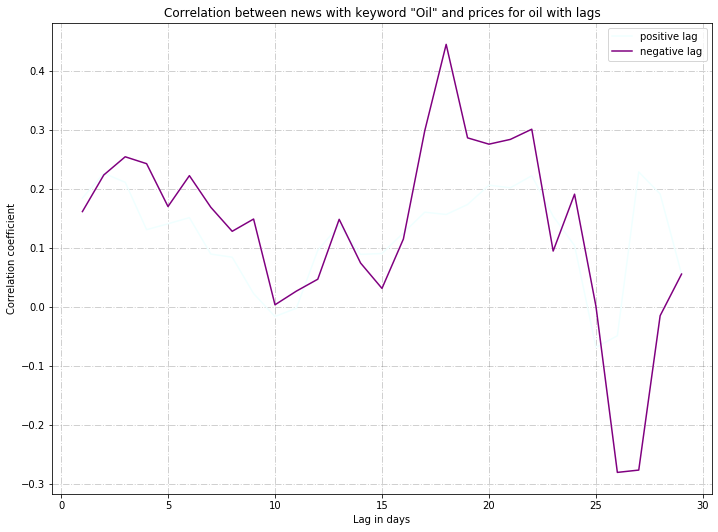

In [26]:
# Correlation news about oil
# Scatterplot
plt.figure() 
#plt.rcParams['figure.figsize'] = [16/2.54, 12/2.54]
#plt.scatter(new_oil_df2['Close_n'].shift(periods = 0), df_daily['sentiment'].shift(periods = 0) )
#plt.title('Tweets sentiment vs oil price')
#plt.rcParams['figure.figsize'] = [28/2.54, 16/2.54]
#plt.show()

# Calculating correlation
correlation = new_oil_df['Close_n'].corr(sent_news['oil'])

print( 'Correlation is ', round(correlation, 4))

# Correlation with lags

correlation_df = pd.Series([])
correlation_df_rev = pd.Series([])
#
for i in range (1, 30):
        correlation_df[i] = new_oil_df['Close_n'].shift(periods = i).corr(
            sent_news['oil'].shift(periods = -i))
        correlation_df_rev[i] = new_oil_df['Close_n'].shift(periods = -i).corr(
            sent_news['oil'].shift(periods = i))
        print( 'Correlation with lag in ', i, 'day is ' , round(correlation_df[i], 4))
        
plt.plot(correlation_df, color = 'azure')
plt.plot(correlation_df_rev, color = 'purple')
plt.rcParams['figure.figsize'] = [30/2.54, 22/2.54]
plt.title('Correlation between news with keyword "Oil" and prices for oil with lags')
plt.xlabel('Lag in days')
plt.legend(('positive lag', 'negative lag'), loc='best')
plt.ylabel('Correlation coefficient')
plt.grid(b=True, color='0.4', alpha=0.3, linestyle='-.', linewidth=1) 
plt.show()


# oil data for tweets

In [69]:
# read oil data for tweets
oil_df2 = pd.read_csv(input_oil_for_tweets)
#print(oil_df2.describe)
oil_df2['Date'] = pd.to_datetime(oil_df2['Date'])
new_oil_df2 = oil_df2[['Date', 'Close']]
print(new_oil_df2.describe())
new_oil_df2.set_index('Date', inplace = True)
# resampling
new_oil_df2 =new_oil_df2.resample('D').mean().ffill()
#new_oil_df2 = new_oil_df['2020-03-21':]
w_oil_df2 =new_oil_df2.resample('W').mean()
# Normalizing between -1 and 1
new_oil_df2['Close_n']= 2*((new_oil_df2['Close'] - new_oil_df2['Close'].min())/(new_oil_df2['Close'].max()-new_oil_df2['Close'].min()))-1
w_oil_df2['Close_n']= 2*((w_oil_df2['Close'] - w_oil_df2['Close'].min())/(w_oil_df2['Close'].max()-w_oil_df2['Close'].min()))-1
print(new_oil_df2.describe())
print(new_oil_df2.shape)
print(w_oil_df2.head())
print(w_oil_df2.describe())
print(w_oil_df2.shape)
print(w_oil_df2.head())

           Close
count  39.000000
mean   19.880770
std     5.963117
min    -2.720000
25%    17.175000
50%    20.480000
75%    24.045000
max    29.000000
           Close    Close_n
count  48.000000  48.000000
mean   20.450417   0.460934
std     5.789844   0.365059
min    -2.720000  -1.000000
25%    17.885001   0.299180
50%    21.025001   0.497163
75%    24.344999   0.706494
max    29.000000   1.000000
(48, 2)
                Close   Close_n
Date                           
2020-03-22  24.453334  0.941864
2020-03-29  22.902857  0.694099
2020-04-05  24.817143  1.000000
2020-04-12  24.582858  0.962561
2020-04-19  19.607144  0.167447
           Close   Close_n
count   8.000000  8.000000
mean   20.926786  0.378324
std     4.687409  0.749044
min    12.301429 -1.000000
25%    18.613572  0.008675
50%    23.009762  0.711182
75%    24.485715  0.947038
max    24.817143  1.000000
(8, 2)
                Close   Close_n
Date                           
2020-03-22  24.453334  0.941864
2020-03-29  22.90

# Sentiment level in the oil groups of tweets and news vs prices for oil

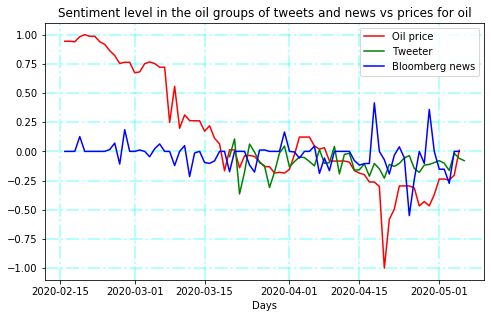

In [52]:
# plotting Oil vs Tweets and news
# Plotting sentiment scores
#plt.plot(# Sentiment analysis for Bloomberg news
#
plt.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
# Plotting sentiment scores
plt.plot(df_daily.index, df_daily['oil'], color = 'green')
plt.plot(sent_news.index, sent_news['oil'], color = 'blue')
#plt.plot(df_daily.index, df_daily['renewable'], color = 'seagreen')
#plt.plot(df_daily.index, df_daily['climate'], color = 'blue')
#plt.plot(df_daily.index, df_daily['gas'], color = 'brown')
#plt.plot(df_daily.index, df_daily['oil'], color = 'yellow')
#plt.plot(df_daily.index, df_daily['Bloomberg'], color = 'purple')
#plt.plot(df_daily.index, df_daily['coronavirus'], color = 'crimson')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
#plt.ylabel('oil')
plt.title('Sentiment level in the oil groups of tweets and news vs prices for oil')
plt.rcParams['figure.figsize'] = [30/2.54,12/2.54]
plt.legend(('Oil price', 'Tweeter', 'Bloomberg news'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# plotting Oil vs Tweets weekly

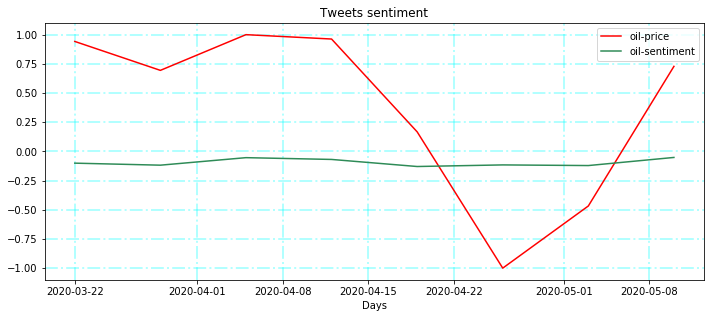

In [53]:

# Plotting sentiment scores
#plt.plot(# Sentiment analysis for Bloomberg news
#
plt.plot(w_oil_df2.index, w_oil_df2['Close_n'], color = 'red')
# Plotting sentiment scores
#plt.plot(df_weekly.index, df_weekly['sentiment'], color = 'green')
#plt.plot(df_weekly.index, df_weekly['renewable'], color = 'seagreen')
#plt.plot(df_weekly.index, df_weekly['climate'], color = 'blue')
#plt.plot(df_weekly.index, df_weekly['gas'], color = 'brown')
plt.plot(df_weekly.index, df_weekly['oil'], color = 'seagreen')
#plt.plot(df_weekly.index, df_weekly['Bloomberg'], color = 'purple')
#plt.plot(df_weekly.index, df_weekly['coronavirus'], color = 'crimson')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
#plt.ylabel('oil')
plt.title('Tweets sentiment')
plt.rcParams['figure.figsize'] = [30/2.54,12/2.54]
plt.legend(('oil-price', 'oil-sentiment' ), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

#  Correlation tweets

In [78]:
# Calculating correlation
correlation = new_oil_df2['Close_n'].corr(df_daily['sentiment'])
correlation_oil = new_oil_df2['Close_n'].corr(df_daily['oil'])
print('daily frequency')
print( 'Correlation is ', round(correlation, 4))
print( 'Correlation_oil  is ', round(correlation_oil, 4))

correlation = w_oil_df2['Close_n'].corr(df_weekly['sentiment'])
correlation_oil = w_oil_df2['Close_n'].corr(df_weekly['oil'])

print('Weekly frequency')
print( 'Correlation is ', round(correlation, 4))
print( 'Correlation_oil  is ', round(correlation_oil, 4))

sma_oil_price =new_oil_df2['Close_n'].rolling(window = 4).mean()
sma_news = df_daily['sentiment'].rolling(window = 4).mean()
sma_news_oil = df_daily['oil'].rolling(window = 4).mean()
correlation = sma_oil_price.corr(sma_news)
correlation_oil = sma_oil_price.corr(sma_news_oil)

print('SMA')
print( 'Correlation is ', round(correlation, 4))
print( 'Correlation_oil  is ', round(correlation_oil, 4))

daily frequency
Correlation is  0.0641
Correlation_oil  is  0.3488
Weekly frequency
Correlation is  0.1003
Correlation_oil  is  0.6198
SMA
Correlation is  -0.1608
Correlation_oil  is  0.577


# tweets Sentiment vs Coronavirus

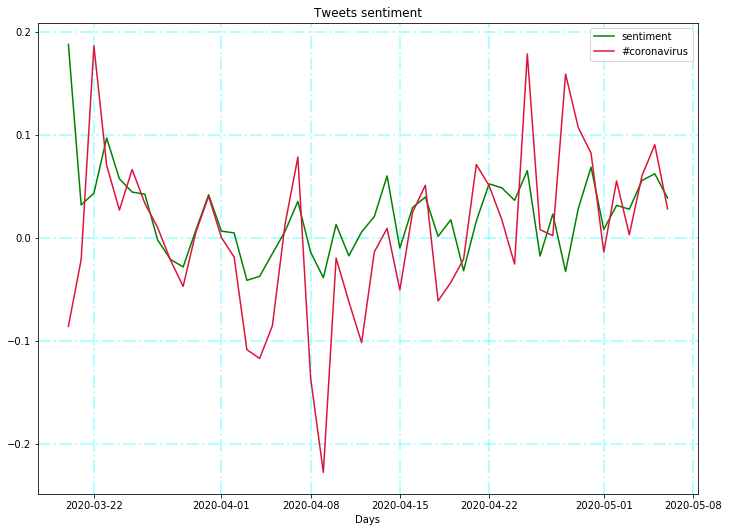

In [55]:
# tweets Sentiment vs Coronavirus
plt.figure() 
# plotting Oil vs Tweets
# Plotting sentiment scores in tweets
#plt.plot(new_oil_df2.index, new_oil_df2['Close_n'], color = 'red')
# Plotting sentiment scores
plt.plot(df_daily.index, df_daily['sentiment'], color = 'green')
#plt.plot(df_daily.index, df_daily['renewable'], color = 'seagreen')
#plt.plot(df_daily.index, df_daily['climate'], color = 'blue')
#plt.plot(df_daily.index, df_daily['gas'], color = 'brown')
#plt.plot(df_daily.index, df_daily['oil'], color = 'yellow')
#plt.plot(df_daily.index, df_daily['Bloomberg'], color = 'purple')
plt.plot(df_daily.index, df_daily['coronavirus'], color = 'crimson')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
#plt.ylabel('oil')
plt.title('Tweets sentiment')
plt.rcParams['figure.figsize'] = [30/2.54,12/2.54]
plt.legend(('sentiment', '#coronavirus'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# tweets Sentiment vs oil and gas sentiment

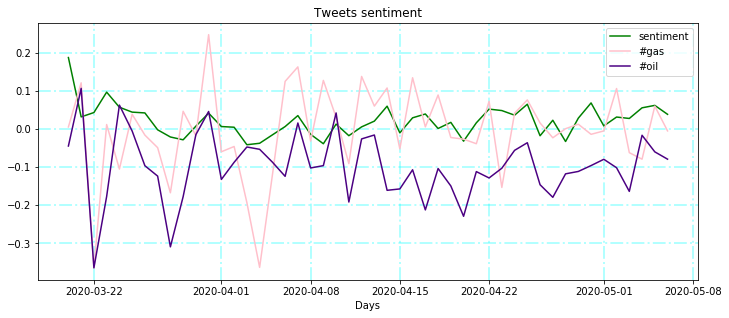

In [56]:
# tweets Sentiment vs oil and gas sentiment
plt.figure() 
# plotting Oil vs Tweets
# Plotting sentiment scores in tweets
#plt.plot(new_oil_df2.index, new_oil_df2['Close_n'], color = 'red')
# Plotting sentiment scores
plt.plot(df_daily.index, df_daily['sentiment'], color = 'green')
#plt.plot(df_daily.index, df_daily['renewable'], color = 'seagreen')
#plt.plot(df_daily.index, df_daily['climate'], color = 'blue')
plt.plot(df_daily.index, df_daily['gas'], color = 'pink')
plt.plot(df_daily.index, df_daily['oil'], color = 'indigo')
#plt.plot(df_daily.index, df_daily['Bloomberg'], color = 'purple')
#plt.plot(df_daily.index, df_daily['coronavirus'], color = 'crimson')
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)     
plt.xlabel('Days')
#plt.ylabel('oil')
plt.title('Tweets sentiment')
plt.rcParams['figure.figsize'] = [30/2.54,12/2.54]
plt.legend(('sentiment', '#gas', '#oil'), loc='best')
#plt.legend(('renewable', 'gas', 'oil', 'climate', 'energy', 'Bloomberg', 'coronavirus'))
plt.show()

# rolling mean
# tweets

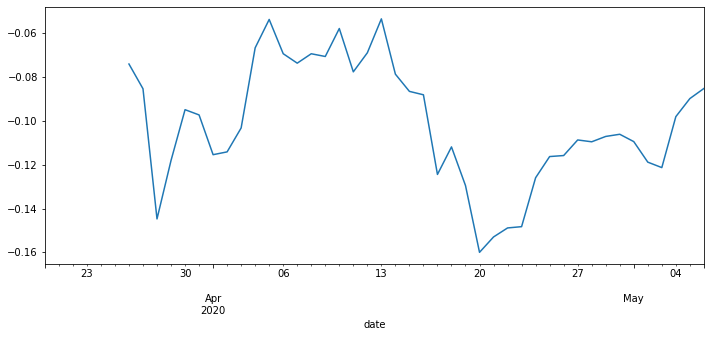

In [57]:
# rolling mean
# tweets
df_daily['mean_oil'] = df_daily['oil'].rolling(window = 7).mean()
df_daily['mean_oil'].plot()
plt.show()

# Rolling mean and variance tweets

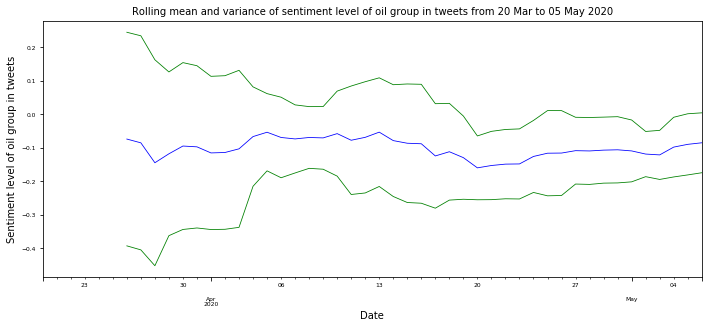

In [58]:
# Rolling mean and variance tweets
df_daily['std_oil'] = df_daily['oil'].rolling(window = 7).std()
#print(df_daily_std)
df_daily['upper'] = df_daily['mean_oil'] + (df_daily['std_oil'] * 2)
df_daily['lower'] = df_daily['mean_oil'] - (df_daily['std_oil'] * 2)
#print(df_daily['mean_oil'])
ax =df_daily['mean_oil'].plot(linewidth=0.8, fontsize=6, color = "blue")
ax =df_daily['upper'].plot(linewidth=0.8, fontsize=6, color = "green")
ax =df_daily['lower'].plot(linewidth=0.8, fontsize=6, color = "green")
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Sentiment level of oil group in tweets', fontsize=10)
ax.set_title('Rolling mean and variance of sentiment level of oil group in tweets from 20 Mar to 05 May 2020', fontsize=10)
plt.show()

# rolling mean
# news

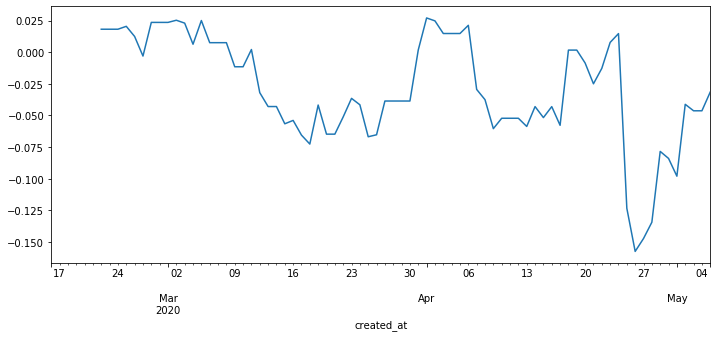

In [59]:
# rolling mean
# news
sent_news['mean_oil'] = sent_news['oil'].rolling(window = 7).mean()
sent_news['mean_oil'].plot()
plt.show()

# Rolling mean and variance news

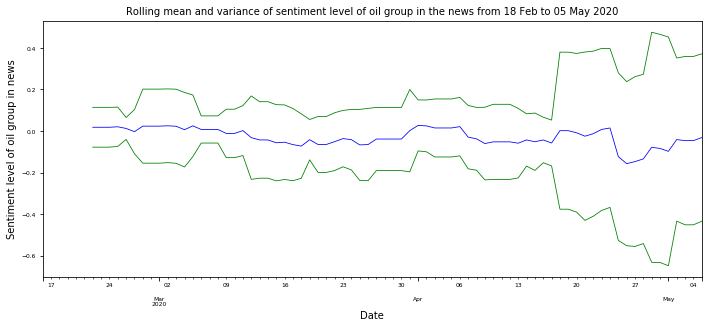

In [60]:
# Rolling mean and variance news
sent_news['std_oil'] = sent_news['oil'].rolling(window = 7).std()
#print(df_daily_std)
sent_news['upper'] = sent_news['mean_oil'] + (sent_news['std_oil'] * 2)
sent_news['lower'] = sent_news['mean_oil'] - (sent_news['std_oil'] * 2)
#print(df_daily_mean)
ax =sent_news['mean_oil'].plot(linewidth=0.8, fontsize=6, color = "blue")
ax =sent_news['upper'].plot(linewidth=0.8, fontsize=6, color = "green")
ax =sent_news['lower'].plot(linewidth=0.8, fontsize=6, color = "green")
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Sentiment level of oil group in news', fontsize=10)
ax.set_title('Rolling mean and variance of sentiment level of oil group in the news from 18 Feb to 05 May 2020', fontsize=10)
plt.show()

# 3 subplots news vs oil daily

<function matplotlib.pyplot.show(*args, **kw)>

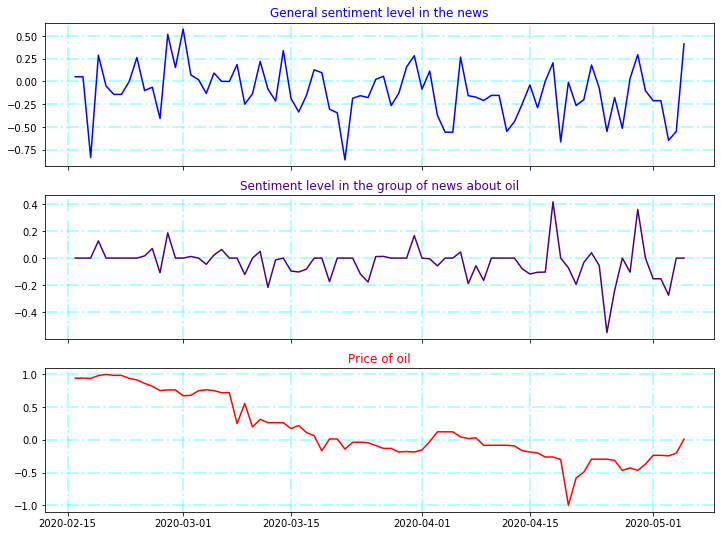

In [61]:
# 3 subplots news vs oil daily
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
#ax1.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
#ax2.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
#ax3.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(new_oil_df.index, sent_news['sentiment'], color = 'blue')
ax1.set_title('General sentiment level in the news', color = 'blue')
ax2.plot(new_oil_df.index, sent_news['oil'], color = 'indigo')
ax2.set_title('Sentiment level in the group of news about oil', color = 'indigo')
ax3.plot(new_oil_df.index, new_oil_df['Close_n'], color = 'red')
ax3.set_title('Price of oil', color = 'red')

plt.show

# 3 subplots news vs oil weekly

<function matplotlib.pyplot.show(*args, **kw)>

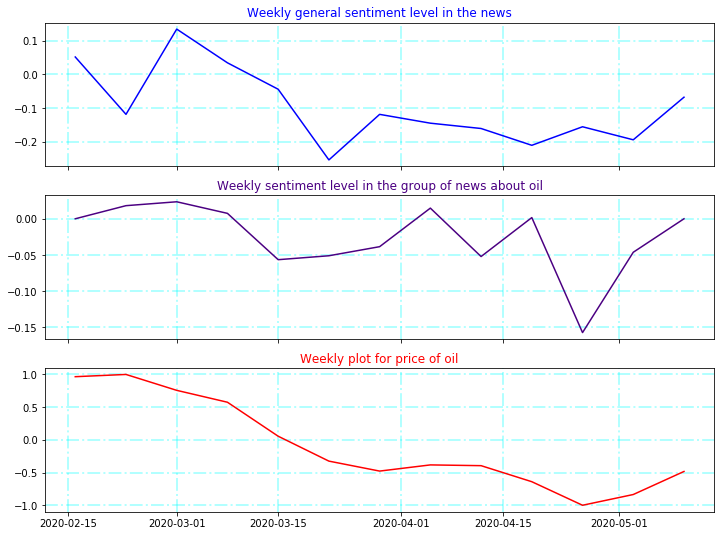

In [62]:
# 3 subplots news vs oil weekly
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
#ax1.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
#ax2.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
#ax3.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(w_oil_df.index, w_sent_new['sentiment'], color = 'blue')
ax1.set_title('Weekly general sentiment level in the news', color = 'blue')
ax2.plot(w_oil_df.index, w_sent_new['oil'], color = 'indigo')
ax2.set_title('Weekly sentiment level in the group of news about oil', color = 'indigo')
ax3.plot(w_oil_df.index, w_oil_df['Close_n'], color = 'red')
ax3.set_title('Weekly plot for price of oil', color = 'red')

plt.show

# 3 subplots tweets vs oil daily

<function matplotlib.pyplot.show(*args, **kw)>

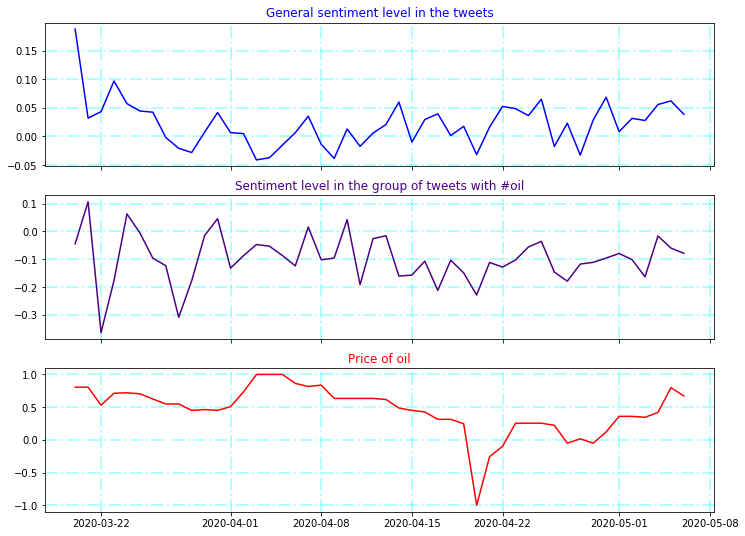

In [63]:
# 3 subplots tweets vs oil daily
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(new_oil_df2.index, df_daily['sentiment'], color = 'blue')
ax1.set_title('General sentiment level in the tweets', color = 'blue')
ax2.plot(new_oil_df2.index, df_daily['oil'], color = 'indigo')
ax2.set_title('Sentiment level in the group of tweets with #oil', color = 'indigo')
ax3.plot(new_oil_df2.index, new_oil_df2['Close_n'], color = 'red')
ax3.set_title('Price of oil', color = 'red')

plt.show

# 3 subplots tweets vs oil weekly

<function matplotlib.pyplot.show(*args, **kw)>

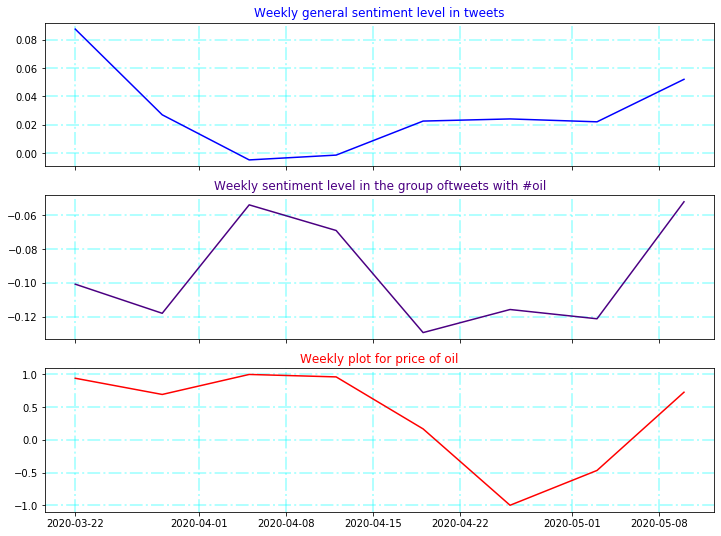

In [76]:
# 3 subplots news vs oil weekly
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
#ax1.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
#ax2.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
#ax3.axvline(pd.to_datetime('2020-04-20'), color='darkgoldenrod', linestyle= '--')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(w_oil_df2.index, df_weekly['sentiment'], color = 'blue')
ax1.set_title('Weekly general sentiment level in tweets', color = 'blue')
ax2.plot(w_oil_df2.index, df_weekly['oil'], color = 'indigo')
ax2.set_title('Weekly sentiment level in the group oftweets with #oil', color = 'indigo')
ax3.plot(w_oil_df2.index, w_oil_df2['Close_n'], color = 'red')
ax3.set_title('Weekly plot for price of oil', color = 'red')

plt.show

#  Rolling means oil vs news

Text(0.5, 1.0, 'Simple moving average of Price of oil')

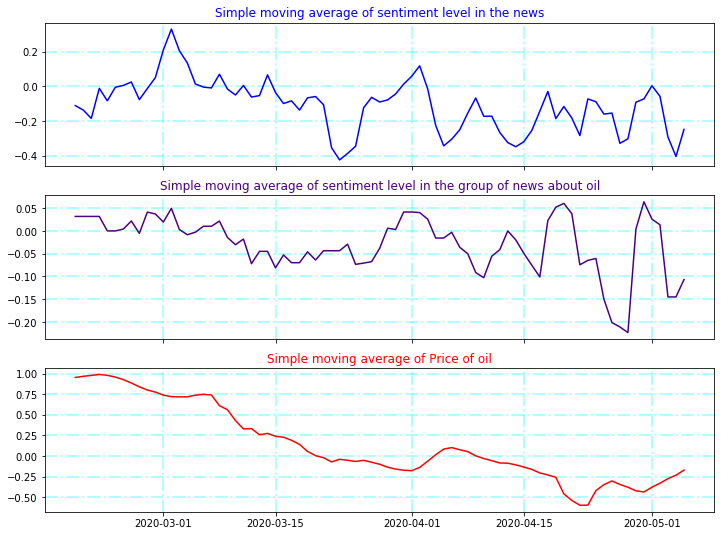

In [73]:
# Rolling means oil vs news
# rolling mean
# tweets
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(new_oil_df.index, sent_news['sentiment'].rolling(window = 4).mean(), color = 'blue')
ax1.set_title('Simple moving average of sentiment level in the news', color = 'blue')
ax2.plot(new_oil_df.index, sent_news['oil'].rolling(window = 4).mean(), color = 'indigo')
ax2.set_title('Simple moving average of sentiment level in the group of news about oil', color = 'indigo')
ax3.plot(new_oil_df.index, new_oil_df['Close_n'].rolling(window = 4).mean(), color = 'red')
ax3.set_title('Simple moving average of Price of oil', color = 'red')

# Rolling means oil vs tweets week

Text(0.5, 1.0, 'Simple moving average of Price of oil')

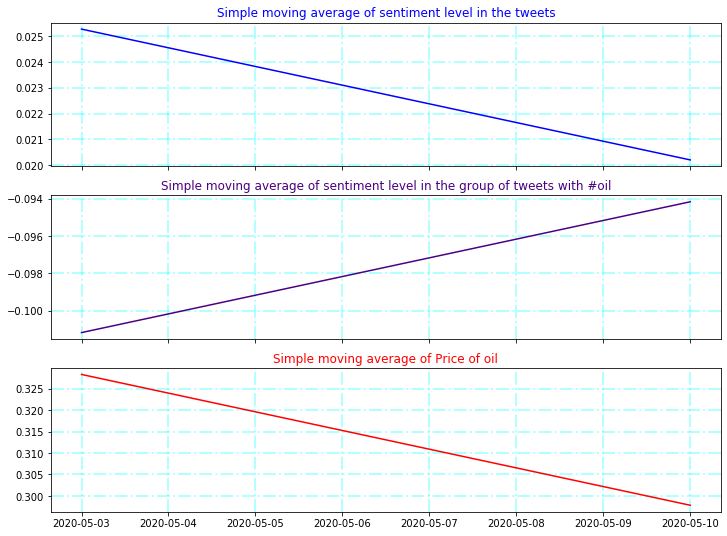

In [64]:
# Rolling means oil vs tweets
# rolling mean
# tweets
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(w_oil_df2.index, df_weekly['sentiment'].rolling(window = 7).mean(), color = 'blue')
ax1.set_title('Simple moving average of sentiment level in the tweets', color = 'blue')
ax2.plot(w_oil_df2.index, df_weekly['oil'].rolling(window = 7).mean(), color = 'indigo')
ax2.set_title('Simple moving average of sentiment level in the group of tweets with #oil', color = 'indigo')
ax3.plot(w_oil_df2.index, w_oil_df2['Close_n'].rolling(window = 7).mean(), color = 'red')
ax3.set_title('Simple moving average of Price of oil', color = 'red')

# Rolling means oil vs tweets

Text(0.5, 1.0, 'Simple moving average of Price of oil')

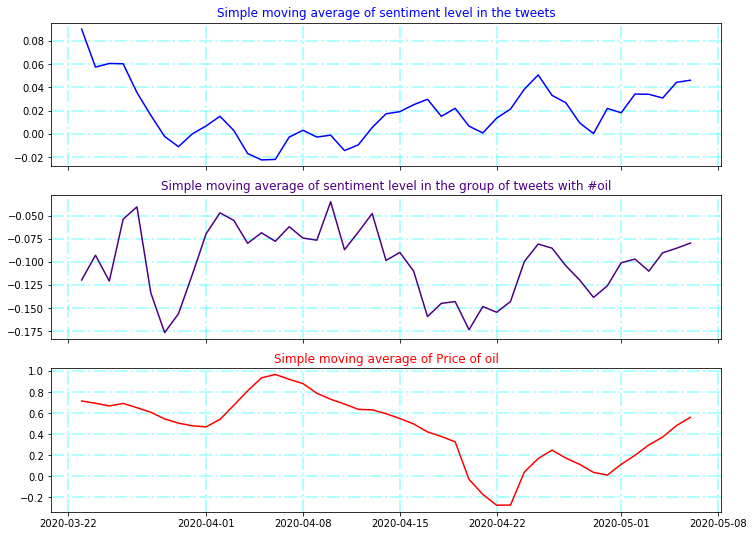

In [77]:
# Rolling means oil vs tweets
# rolling mean
# tweets
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(new_oil_df2.index, df_daily['sentiment'].rolling(window = 4).mean(), color = 'blue')
ax1.set_title('Simple moving average of sentiment level in the tweets', color = 'blue')
ax2.plot(new_oil_df2.index, df_daily['oil'].rolling(window =4).mean(), color = 'indigo')
ax2.set_title('Simple moving average of sentiment level in the group of tweets with #oil', color = 'indigo')
ax3.plot(new_oil_df2.index, new_oil_df2['Close_n'].rolling(window = 4).mean(), color = 'red')
ax3.set_title('Simple moving average of Price of oil', color = 'red')

Text(0.5, 1.0, 'Simple moving average of Price of oil')

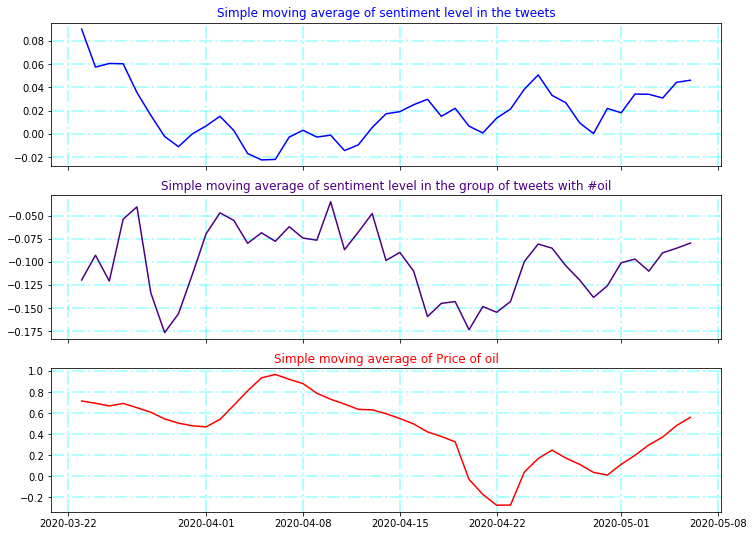

In [68]:
# Rolling means oil vs tweets
# rolling mean
# tweets
fig, (ax1, ax2, ax3) = plt.subplots( 3, sharex=True, figsize=(12,9) )
#fig.suptitle('Visualisation of sentiment level in in the news and tweets and prices of oil ')
ax1.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax2.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax3.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2) 
ax1.plot(new_oil_df2.index, df_daily['sentiment'].rolling(window = 4).mean(), color = 'blue')
ax1.set_title('Simple moving average of sentiment level in the tweets', color = 'blue')
ax2.plot(new_oil_df2.index, df_daily['oil'].rolling(window = 4).mean(), color = 'indigo')
ax2.set_title('Simple moving average of sentiment level in the group of tweets with #oil', color = 'indigo')
ax3.plot(new_oil_df2.index, new_oil_df2['Close_n'].rolling(window = 4).mean(), color = 'red')
ax3.set_title('Simple moving average of Price of oil', color = 'red')

# DataCamp
In the field of time series analysis, autocorrelation refers to the correlation of a time series 
with a lagged version of itself. For example, an autocorrelation of order 3 returns the correlation between
a time series and its own values lagged by 3 time points.
It is common to use the autocorrelation (ACF) plot, also known as self-autocorrelation, to visualize the autocorrelation 
of a time-series. The plot_acf() function in the statsmodels library can be used to measure and plot the autocorrelation of a time series.

fig = tsaplots.plot_acf(co2_levels['co2'], lags=24)

# Display the partial autocorrelation plot of your time series
fig = tsaplots.plot_pacf(co2_levels['co2'], lags=24)

Interpret partial autocorrelation plots
If partial autocorrelation values are close to 0, then values between observations and lagged observations are not correlated with one another. Inversely, partial autocorrelations with values close to 1 or -1 indicate that there exists strong positive or negative correlations between the lagged observations of the time series.

The .plot_pacf() function also returns confidence intervals, which are represented as blue shaded regions. If partial autocorrelation values are beyond this confidence interval regions, then you can assume that the observed partial autocorrelation values are statistically significant.
Time series decomposition
When visualizing time series data, you should look out for some distinguishable patterns:

seasonality: does the data display a clear periodic pattern?
trend: does the data follow a consistent upwards or downward slope?
noise: are there any outlier points or missing values that are not consistent with the rest of the data?
You can rely on a method known as time-series decomposition to automatically extract and quantify the structure of time-series data. The statsmodels library provides the seasonal_decompose() function to perform time series decomposition out of the box.

decomposition = sm.tsa.seasonal_decompose(time_series)
You can extract a specific component, for example seasonality, by accessing the seasonal attribute of the decomposition object.

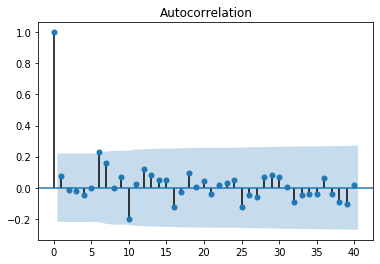

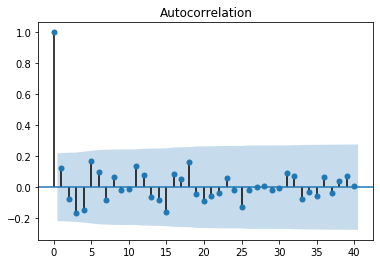

In [85]:
fig = tsaplots.plot_acf(sent_new['sentiment'], lags=40)
plt.show()

fig1 = tsaplots.plot_acf(sent_new['oil'], lags=40)
plt.show()

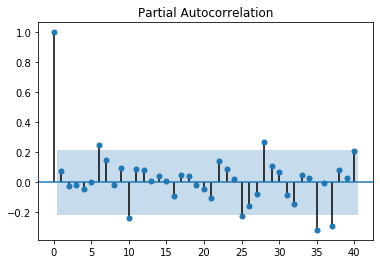

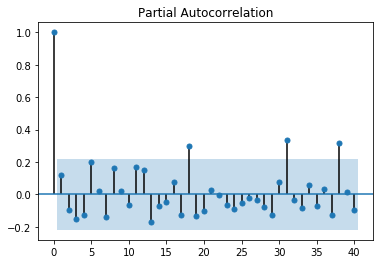

In [87]:
fig = tsaplots.plot_pacf(sent_new['sentiment'], lags=40)
plt.show()
fig = tsaplots.plot_pacf(sent_new['oil'], lags=40)
plt.show()

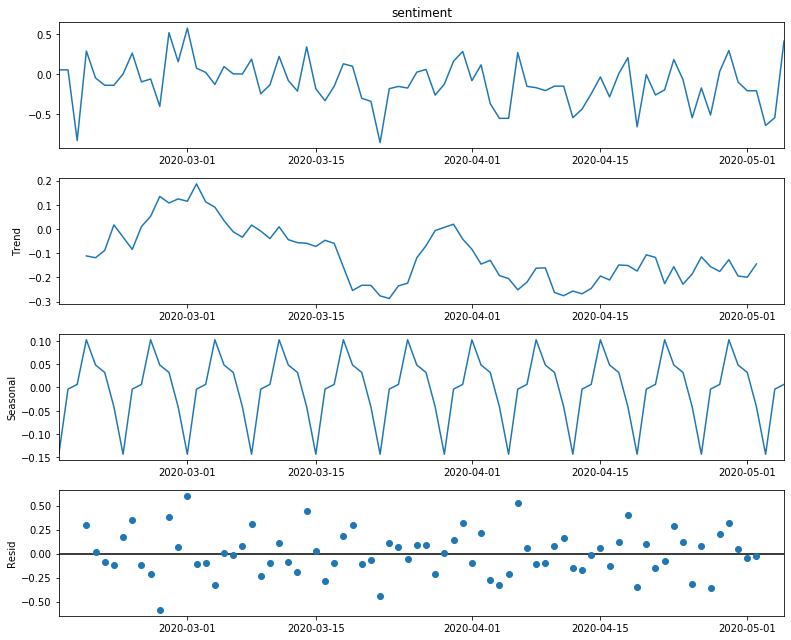

In [88]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(
    sent_new['sentiment'])
fig = decomposition.plot()
plt.show()

# Correlation with lags tweets 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Correlation with lag in  1 day is  0.0325
Correlation with lag in  2 day is  0.0467
Correlation with lag in  3 day is  0.1125
Correlation with lag in  4 day is  -0.0623
Correlation with lag in  5 day is  0.0022
Correlation with lag in  6 day is  -0.1938
Correlation with lag in  7 day is  -0.3186
Correlation with lag in  8 day is  -0.1656
Correlation with lag in  9 day is  0.0654
Correlation with lag in  10 day is  0.2635
Correlation with lag in  11 day is  0.0174
Correlation with lag in  12 day is  -0.0875
Correlation with lag in  13 day is  0.1012
Correlation with lag in  14 day is  0.127
Correlation with lag in  15 day is  0.1141
Correlation with lag in  16 day is  0.3083
Correlation with lag in  17 day is  -0.2464







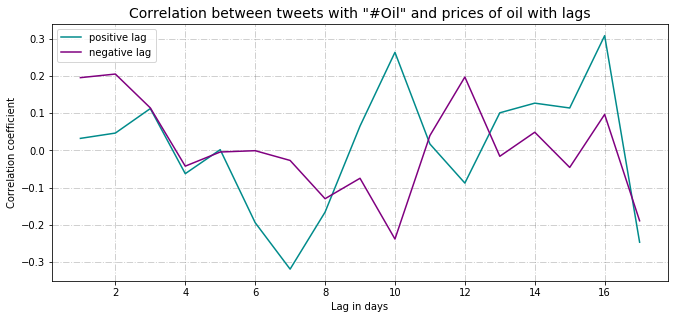

In [103]:

plt.figure() 

# Correlation with lags

correlation_df = pd.Series([])
correlation_df_rev = pd.Series([])
#
for i in range (1, 18):
        correlation_df[i] = new_oil_df2['Close_n'].shift(periods = i).corr(
            df_daily['oil'].shift(periods = -i))
        correlation_df_rev[i] = new_oil_df2['Close_n'].shift(periods = -i).corr(
            df_daily['oil'].shift(periods = i))
        print( 'Correlation with lag in ', i, 'day is ' , round(correlation_df[i], 4))
print('\n\n\n\n') 

plt.plot(correlation_df, color = 'darkcyan')
plt.plot(correlation_df_rev, color = 'purple')
plt.rcParams['figure.figsize'] = [28/2.54, 12/2.54]
plt.title('Correlation between tweets with "#Oil" and prices of oil with lags', fontsize = 14)
plt.xlabel('Lag in days')
plt.legend(('positive lag', 'negative lag'), loc='best')
plt.ylabel('Correlation coefficient')
plt.grid(b=True, color='0.4', alpha=0.3, linestyle='-.', linewidth=1) 
plt.show()

